Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras
import cv2
import random
import math

from tensorflow.keras.applications import ResNet152V2, ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model


Get Image and Label path

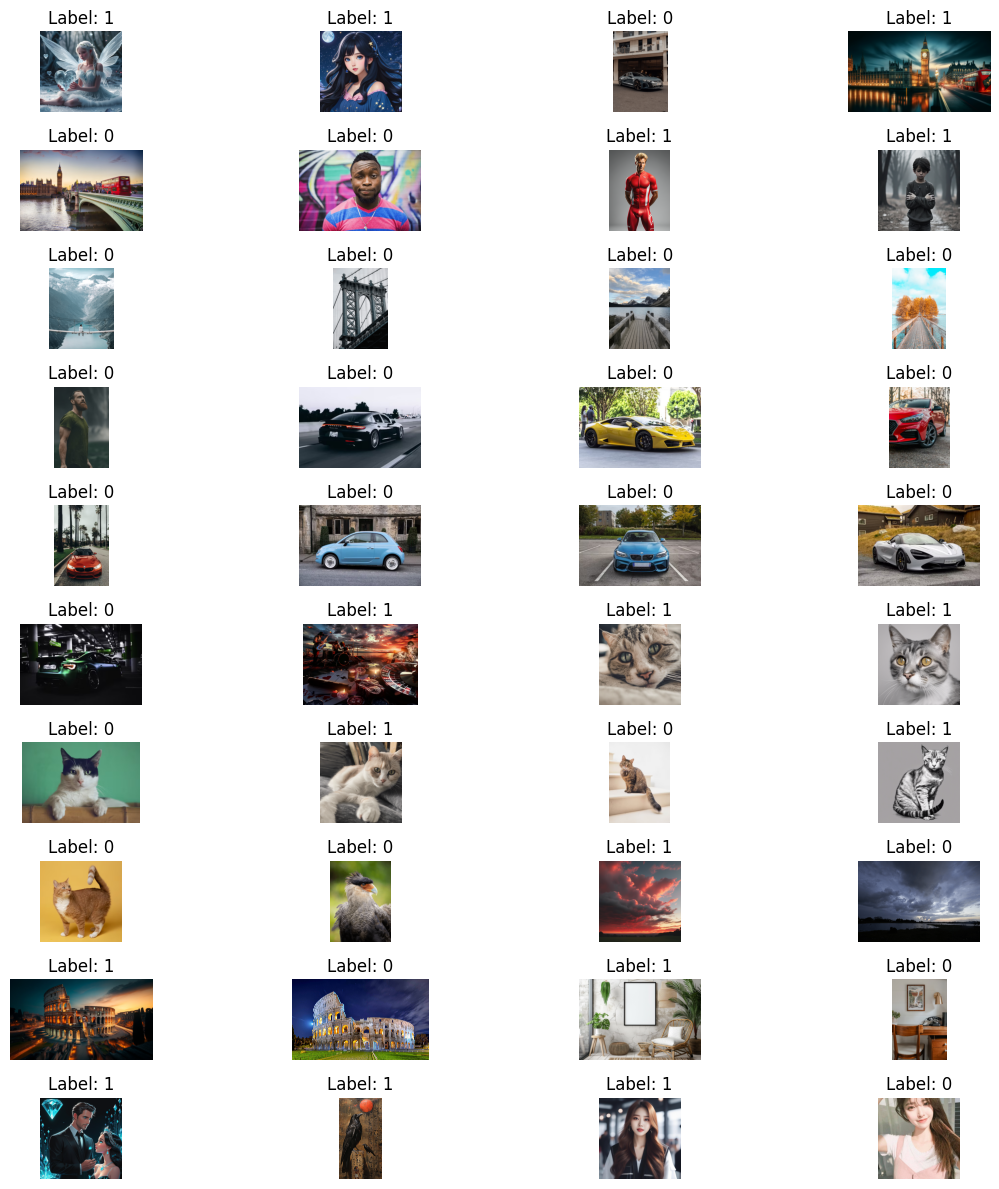

In [2]:
# get label of data
labels_file_path = "./data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]

# get all images
data_path = "./data/Data - Is GenAI - 2024-03-25/"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]
num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
    
plt.tight_layout()
plt.show()

Data Augmentation

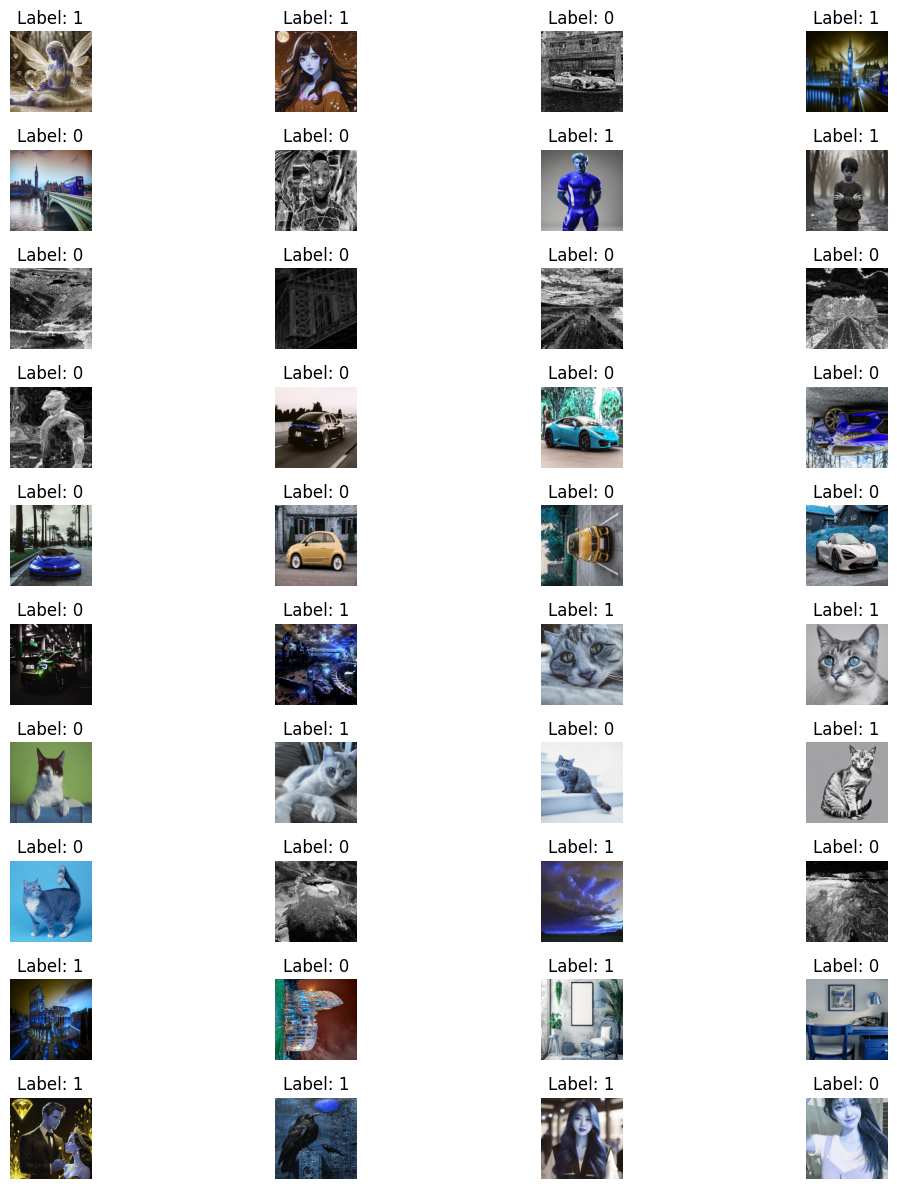

In [3]:
# preprocessed_images = [preprocess_image(image) for image in images]

def preprocess_image_no_blur_function(image):
    preprocess_image = np.array(image)
    preprocess_image = cv2.resize(preprocess_image, (224, 224))
    preprocess_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Randomly decide whether to rotate the image
    if random.random() < 0.1:  # 1/10 chance
        # Randomly choose an angle from [90, 180, 270]
        angle = random.choice([90, 180, 270])
        preprocess_image = rotate(preprocess_image, angle, preserve_range=True).astype(np.uint8)
    elif 0.1 < random.random() < 0.2:
        preprocess_image = cv2.flip(preprocess_image, 1)
        
    return preprocess_image

# def preprocess_image_function(image):
#     preprocess_image = np.array(image)
#     preprocess_image = cv2.resize(preprocess_image, (224, 224))
#     preprocess_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
#     preprocess_image = cv2.GaussianBlur(preprocess_image, (3, 3), 0)
    
#     return preprocess_image

# def flip_images(image):
#     preprocess_image = preprocess_image_function(image)
    
#     flipped_image = cv2.flip(preprocess_image, 1)
#     return flipped_image

# def rotate_90(image):
#     preprocess_image = preprocess_image_function(image)
        
#     rows, cols, _ = preprocess_image.shape
#     rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90, 1)
#     rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
#     return rotated_image

# def rotate_180(image):
#     preprocess_image = preprocess_image_function(image)
        
#     rows, cols, _ = preprocess_image.shape
#     rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 180, 1)
#     rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
#     return rotated_image

# def rotate_270(image):
#     preprocess_image = preprocess_image_function(image)
        
#     rows, cols, _ = preprocess_image.shape
#     rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 270, 1)
#     rotated_image = cv2.warpAffine(preprocess_image, rotation_matrix, (cols, rows))
    
#     return rotated_image

# def adjust_brightness(image):
#     preprocess_image = preprocess_image_function(image)
    
#     hsv_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2HSV)
#     brightness_factor = 0.5  # Specify brightness factor
#     hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_factor, 0, 255)
#     brightened_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    
#     return brightened_image

# def gray_scale(image):
#     preprocess_image = preprocess_image_function(image)
    
#     # Convert the image to grayscale
#     gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2GRAY)
#     # Convert grayscale image to 3-channel format
#     gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    
#     return gray_image

# def apply_gaussian_blur(image):
#     preprocess_image = preprocess_image_function(image)
#     blurred_image = cv2.GaussianBlur(preprocess_image, (5, 5), 0)
#     return blurred_image

# def enhance_contrast(image):
#     preprocess_image = preprocess_image_function(image)  
#     # Convert the image to grayscale
#     gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_RGB2GRAY)
#     # Apply CLAHE
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced_image = clahe.apply(gray_image)
#     # Convert back to 3-channel format
#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
#     return enhanced_image

# Apply the preprocess_image function to the image array
preprocessed_images = []
for image in images:
    preprocessed_images.append(preprocess_image_no_blur_function(image))
    # preprocessed_images.append(preprocess_image_function(image))
    # preprocessed_images.append(flip_images(image))
    # preprocessed_images.append(rotate_90(image))
    # preprocessed_images.append(rotate_180(image))
    # preprocessed_images.append(rotate_270(image))
    # preprocessed_images.append(adjust_brightness(image))
    # preprocessed_images.append(gray_scale(image))
    # preprocessed_images.append(enhance_contrast(image))

# get label of data
labels_file_path = "./data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
# Fix label to be correct with the augment
# labels = [label for label in labels for _ in range(2)]

num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(preprocessed_images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [4]:
# Split the data into train and test sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Convert lists of images to NumPy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# Convert lists of labels to NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

Model Building and Training

Epoch 1/20
81/81 [==============================] - 35s 315ms/step - loss: 0.8045 - accuracy: 0.5464 - val_loss: 0.5539 - val_accuracy: 0.7152 - lr: 2.0000e-04
Epoch 2/20
81/81 [==============================] - 21s 263ms/step - loss: 0.6106 - accuracy: 0.6881 - val_loss: 0.4456 - val_accuracy: 0.8204 - lr: 2.0000e-04
Epoch 3/20
81/81 [==============================] - 21s 255ms/step - loss: 0.5026 - accuracy: 0.7543 - val_loss: 0.3899 - val_accuracy: 0.8560 - lr: 2.0000e-04
Epoch 4/20
81/81 [==============================] - 20s 242ms/step - loss: 0.4472 - accuracy: 0.8069 - val_loss: 0.3575 - val_accuracy: 0.8700 - lr: 2.0000e-04
Epoch 5/20
81/81 [==============================] - 20s 245ms/step - loss: 0.4215 - accuracy: 0.8262 - val_loss: 0.3364 - val_accuracy: 0.8762 - lr: 2.0000e-04
Epoch 6/20
81/81 [==============================] - 20s 246ms/step - loss: 0.3800 - accuracy: 0.8502 - val_loss: 0.3214 - val_accuracy: 0.8854 - lr: 2.0000e-04
Epoch 7/20
81/81 [======================

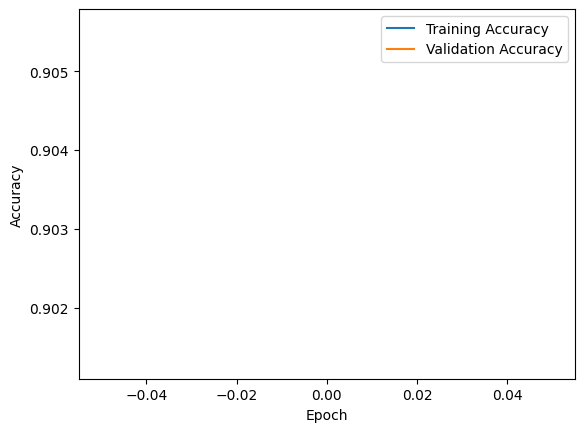

In [5]:
# Define the learning rate decay function
def lr_scheduler(epoch, lr):
    decay_rate = 0.6
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

weight_decay = 1e-5  # Adjust this value as needed

# Load pre-trained Resnet152 model
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
# Freeze all layers except the last few
for layer in resnet_model.layers:
    layer.trainable = False

# Add classification head
model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dropout(0.2),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(weight_decay)),
])

# Compile the model with SGD optimizer and initial learning rate
initial_learning_rate = 0.0002
sgd = SGD(learning_rate=initial_learning_rate)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Define the learning rate scheduler
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with the learning rate scheduler
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=20, batch_size=32, verbose=1,
                    callbacks=[lr_callback])

# Freeze all layers except the last few
for layer in resnet_model.layers:
    layer.trainable = True
    
# Train the model with the learning rate scheduler
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=1, batch_size=32, verbose=1,
                    callbacks=[lr_callback])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
# Save the model weight
model.save_weights("weights/ai_human_classify_model_weights_resnet152_V4.h5")

TestSet 1 Inference

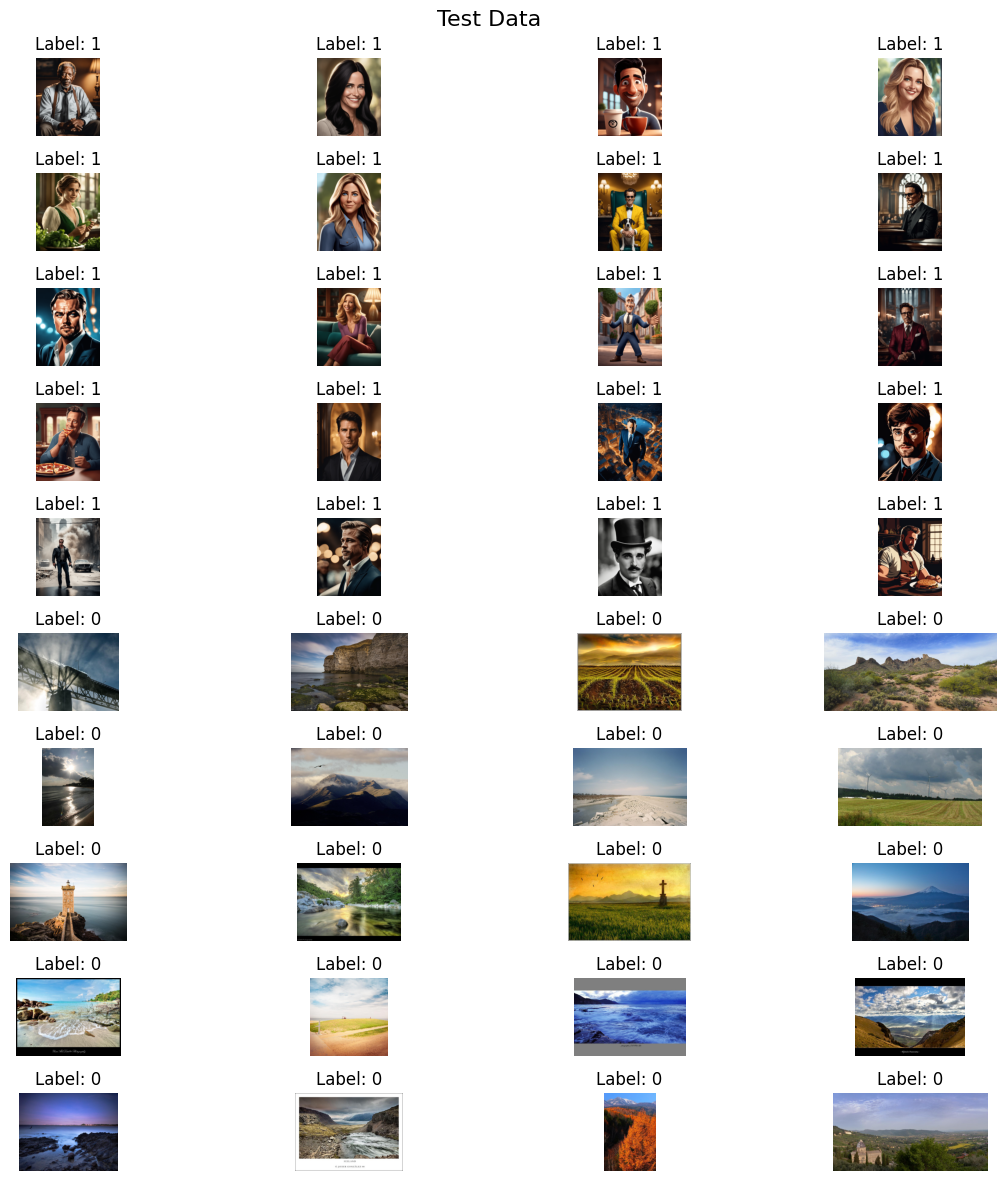

2/2 [==============================] - 4s 953ms/step


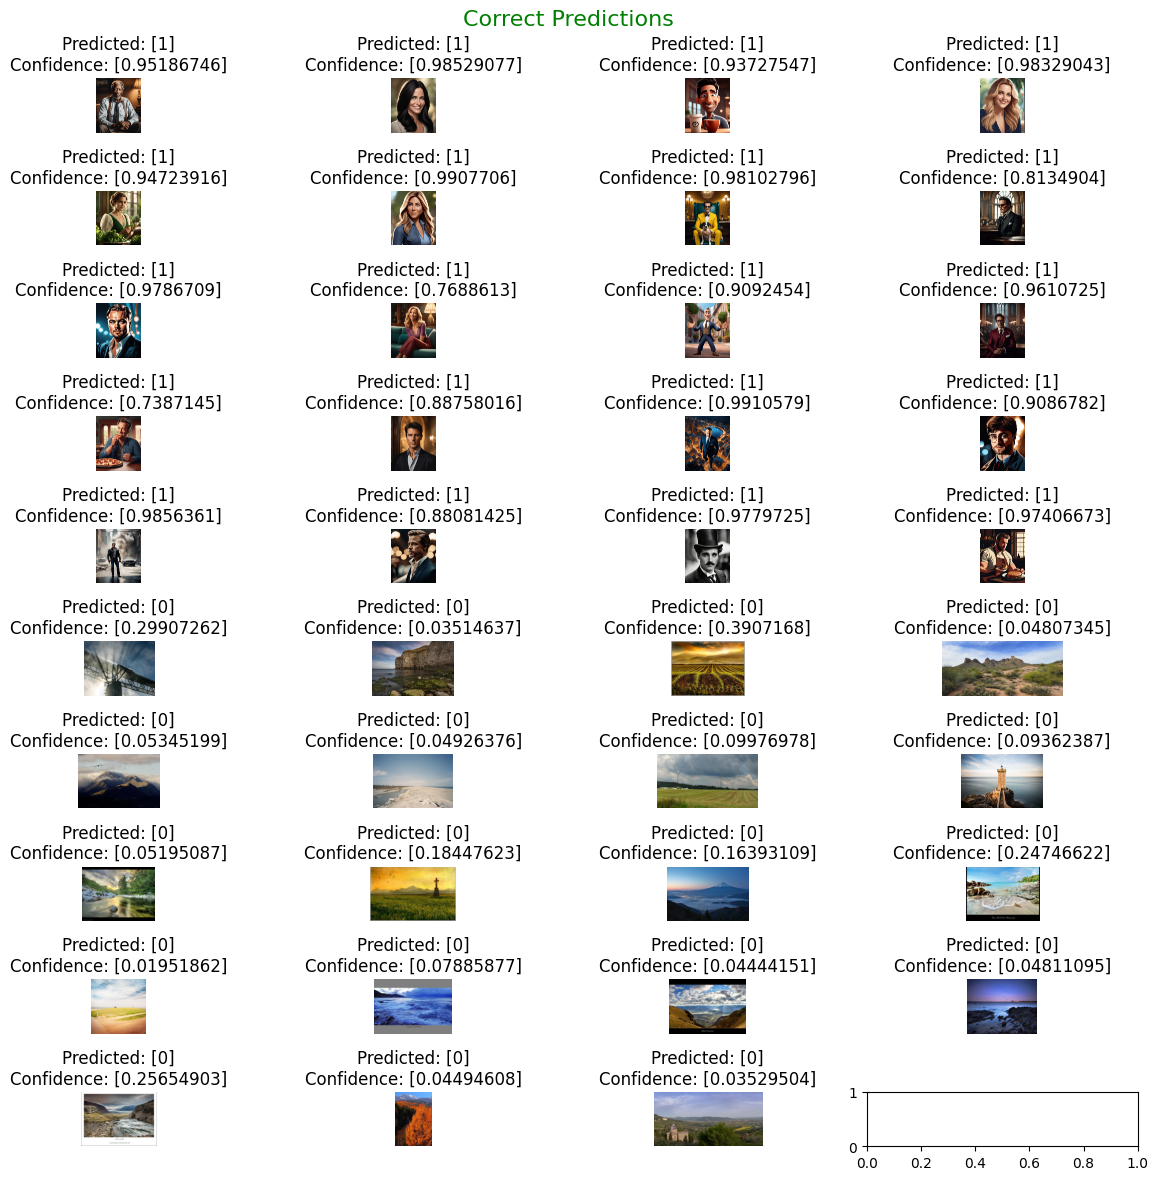

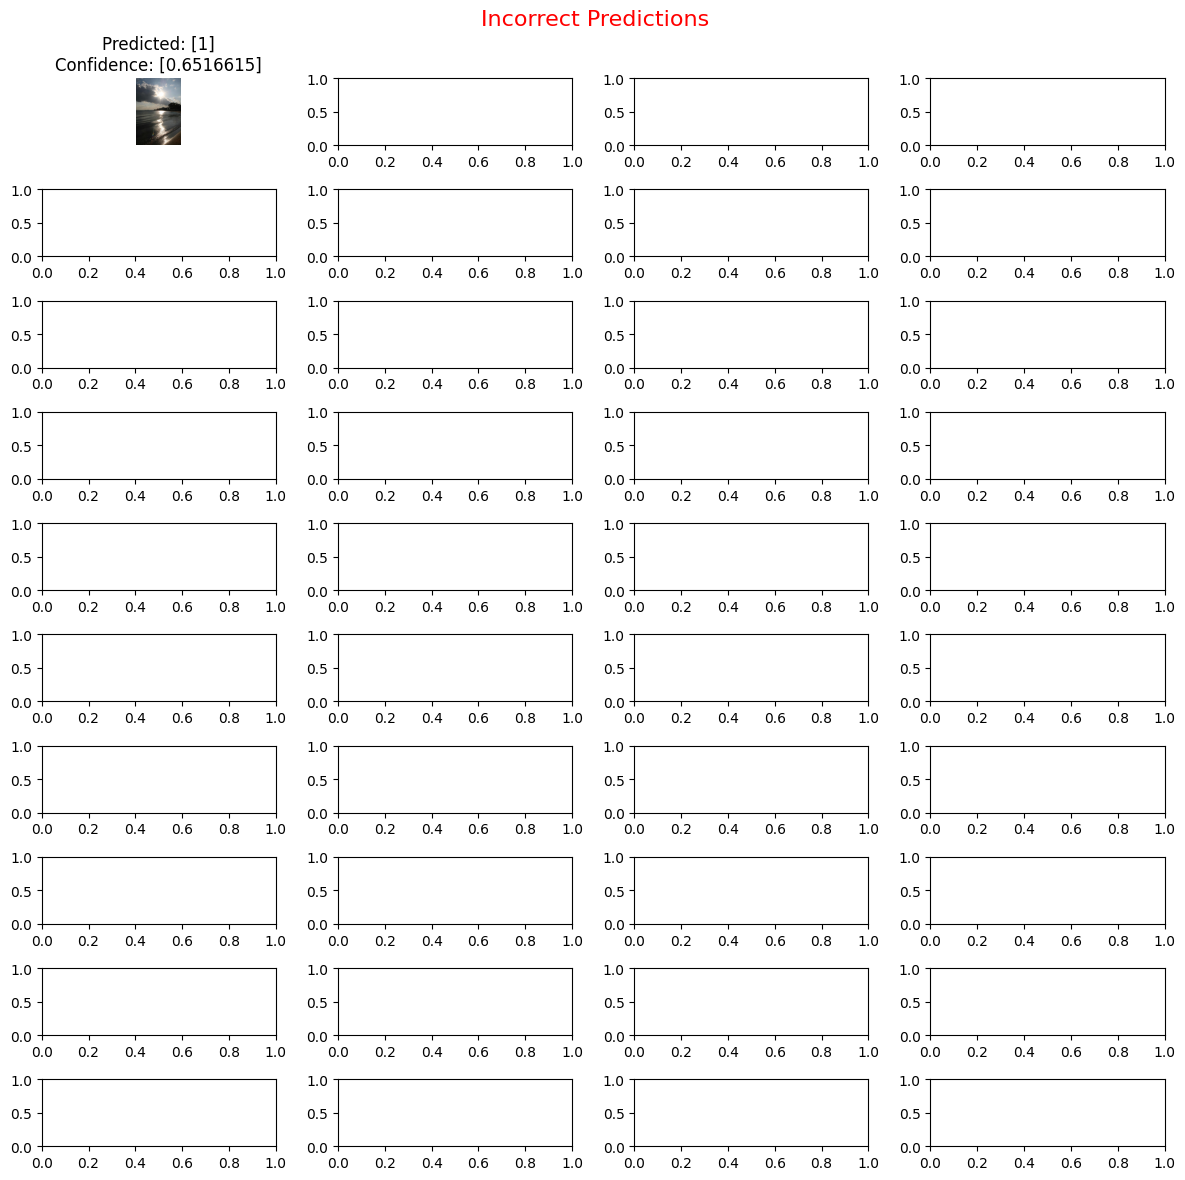

Test Accuracy: 0.975


In [7]:
# get label of data
labels_file_path = "./data/Data - Is GenAI Test 1/file_names.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
labels = np.array(labels)

# get all images
data_path = "./data/Data - Is GenAI Test 1/"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]

predict_images = [preprocess_image_no_blur_function(image) for image in images]

# Preprocess the images
predict_images = np.array(predict_images)

# plot the images and its labels
num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
plt.suptitle("Test Data", fontsize=16, color='black')
plt.tight_layout()
plt.show()

# Predict the labels for the images
predictions = model.predict(predict_images)

# Initialize variables to store the best threshold and its corresponding accuracy
# best_threshold = 0
# best_accuracy = 0
# # Iterate through a range of threshold values
# for threshold in np.linspace(0, 1, 100):
#     # Convert predictions to binary labels using the current threshold
#     binary_predictions = (predictions > threshold).astype(int)
#     # Calculate accuracy
#     accuracy = accuracy_score(labels, binary_predictions)
#     # Update the best threshold and accuracy if the current accuracy is higher
#     if accuracy > best_accuracy:
#         best_threshold = threshold
#         best_accuracy = accuracy
        
# print("Best Threshold: " + str(best_threshold))

# Convert the predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Separate the images into correct and incorrect categories based on predictions
correct_images = []
incorrect_images = []

for i, (image, prediction, label, confidence) in enumerate(zip(images, binary_predictions, labels, predictions)):
    if prediction == label:
        correct_images.append((image, prediction, confidence))
    else:
        incorrect_images.append((image, prediction, confidence))

# Display correct and incorrect images
num_rows = 10
num_cols = 4

# Display correct images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction, confidence) in enumerate(correct_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction) + "\nConfidence: " + str(confidence))
    ax.axis('off')
plt.suptitle("Correct Predictions", fontsize=16, color='green')
plt.tight_layout()
plt.show()

# Display incorrect images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction, confidence) in enumerate(incorrect_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction) + "\nConfidence: " + str(confidence))
    ax.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=16, color='red')
plt.tight_layout()
plt.show()

# Calculate and print the test accuracy
test_accuracy = len(correct_images) / len(images)
print("Test Accuracy:", test_accuracy)

TestSet 2 Inference

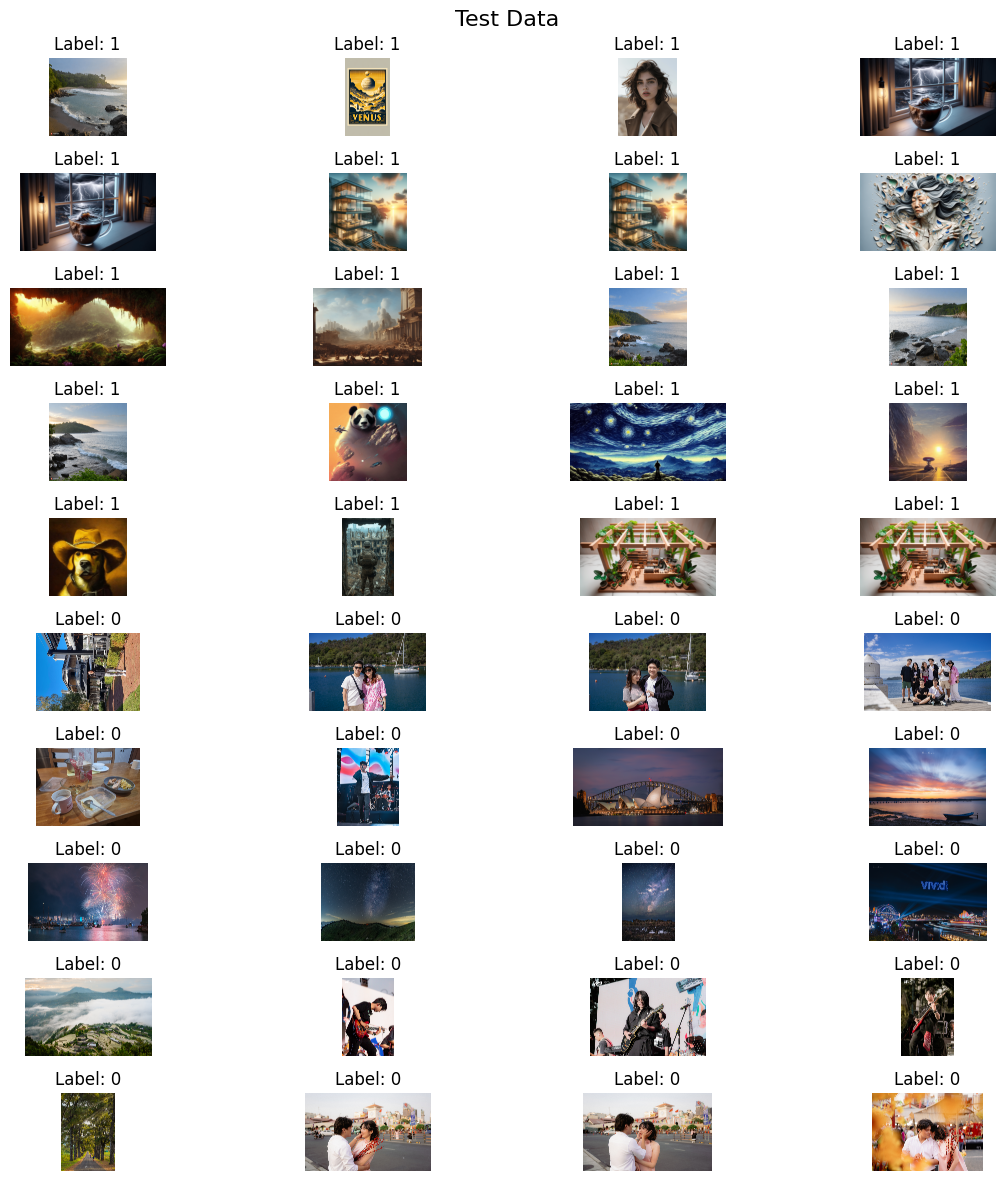

2/2 [==============================] - 1s 602ms/step


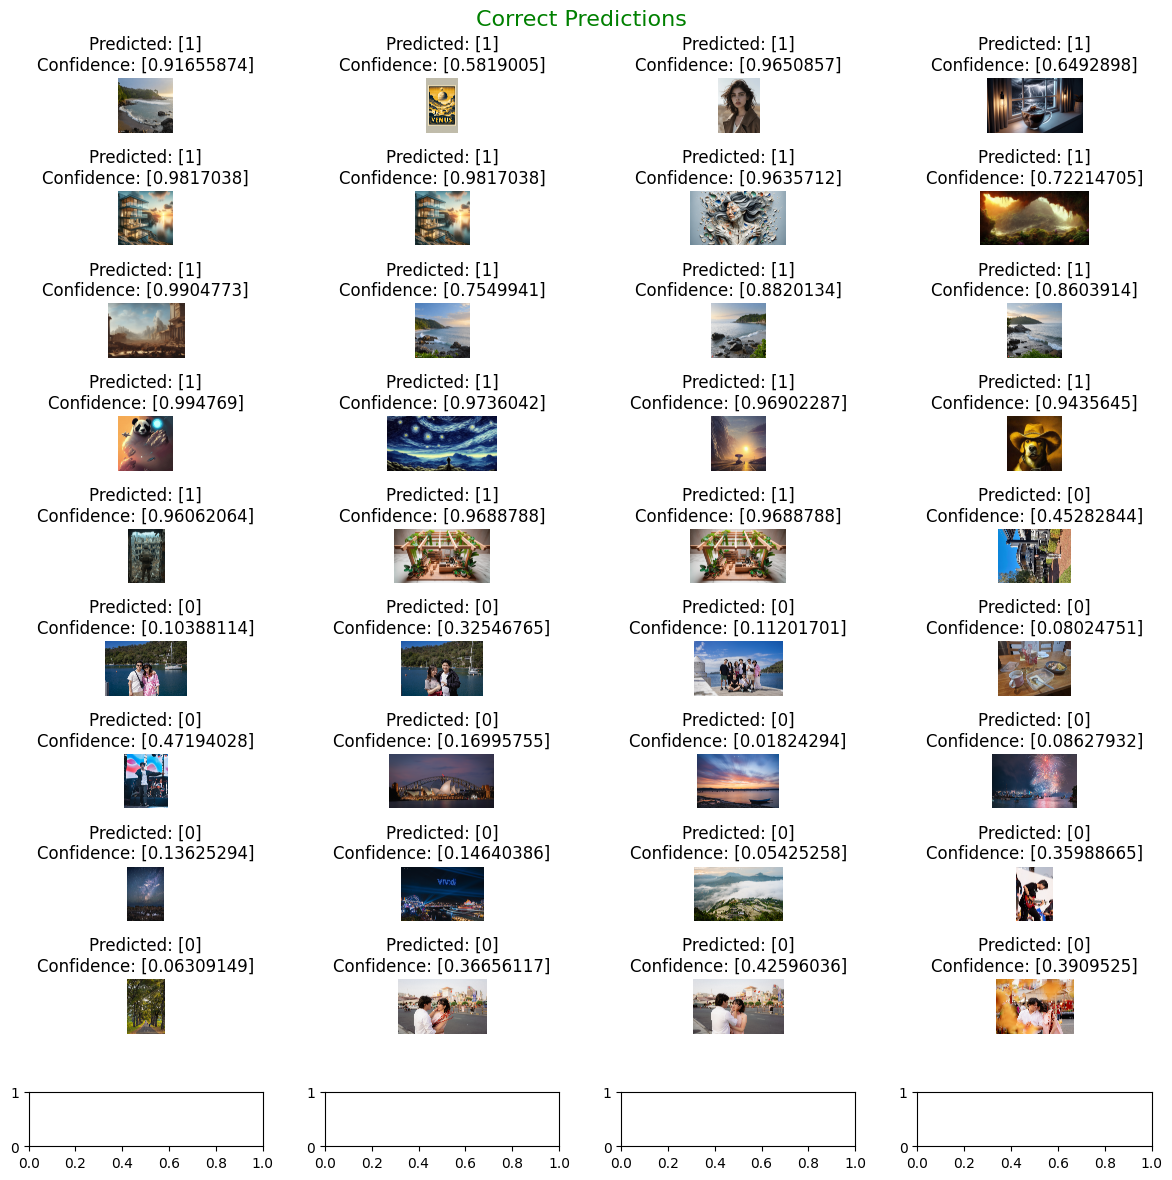

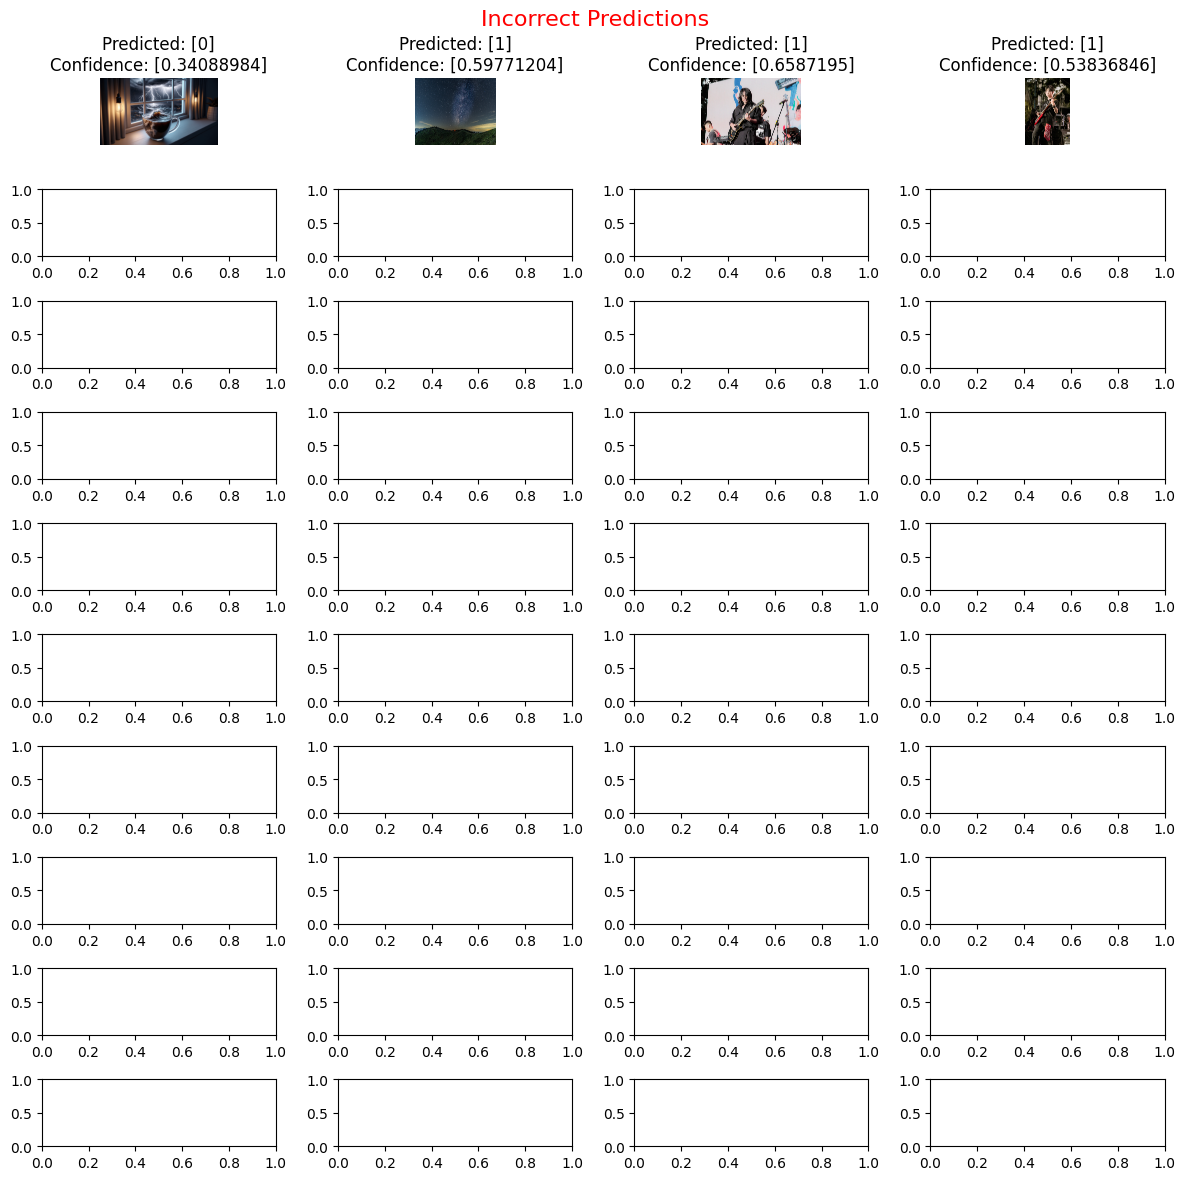

Test Accuracy: 0.9


In [8]:
# get label of data
labels_file_path = "./data/Data - Is GenAI Test 2/file_names.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
labels = np.array(labels)

# get all images
data_path = "./data/Data - Is GenAI Test 2/"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]

predict_images = [preprocess_image_no_blur_function(image) for image in images]

# Preprocess the images
predict_images = np.array(predict_images)

# plot the images and its labels
num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
plt.suptitle("Test Data", fontsize=16, color='black')
plt.tight_layout()
plt.show()

# Predict the labels for the images
predictions = model.predict(predict_images)

# Convert the predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Separate the images into correct and incorrect categories based on predictions
correct_images = []
incorrect_images = []

for i, (image, prediction, label, confidence) in enumerate(zip(images, binary_predictions, labels, predictions)):
    if prediction == label:
        correct_images.append((image, prediction, confidence))
    else:
        incorrect_images.append((image, prediction, confidence))

# Display correct and incorrect images
num_rows = 10
num_cols = 4

# Display correct images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction, confidence) in enumerate(correct_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction) + "\nConfidence: " + str(confidence))
    ax.axis('off')
plt.suptitle("Correct Predictions", fontsize=16, color='green')
plt.tight_layout()
plt.show()

# Display incorrect images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i, (image, prediction, confidence) in enumerate(incorrect_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    ax.set_title("Predicted: " + str(prediction) + "\nConfidence: " + str(confidence))
    ax.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=16, color='red')
plt.tight_layout()
plt.show()

# Calculate and print the test accuracy
test_accuracy = len(correct_images) / len(images)
print("Test Accuracy:", test_accuracy)